# Quantum Support Vector Machine (QSVM)

Support Vector Machine is an binary classification algorithm that falls in the category of supervised learning. “Binary” means that it can only classify in two groups. This is not really a limitation, since once you can separate in two groups, you can easily generalize the classification in more groups by applying the algorithm multiple times.

### Objective 1: 
    
Draw a straight line that separates two sets of data (positive and negative samples) with the view towards putting in the widest street that separates the positive from the negative samples (widest street approach).
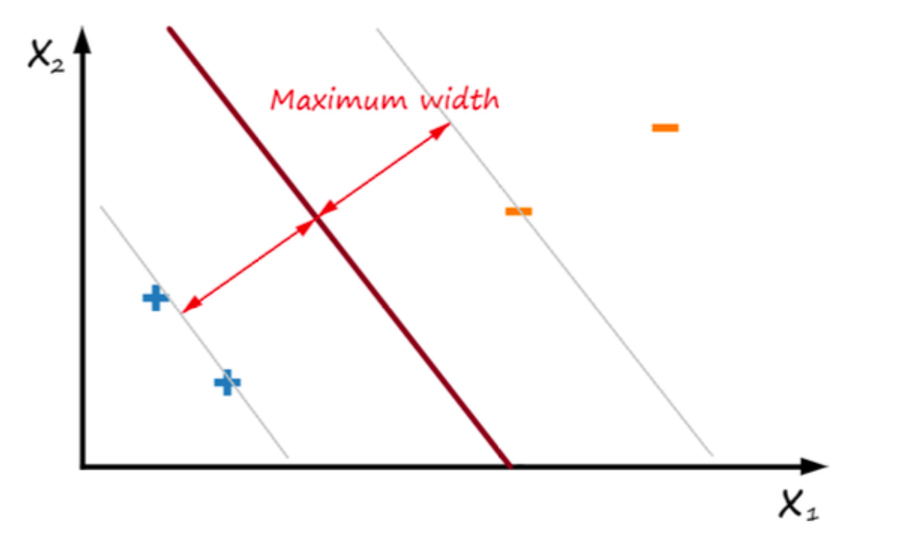

### Objective 2:

Find a decision rule that describes such a straight line and uses it to classify a new data point into the positive or the negative sets.
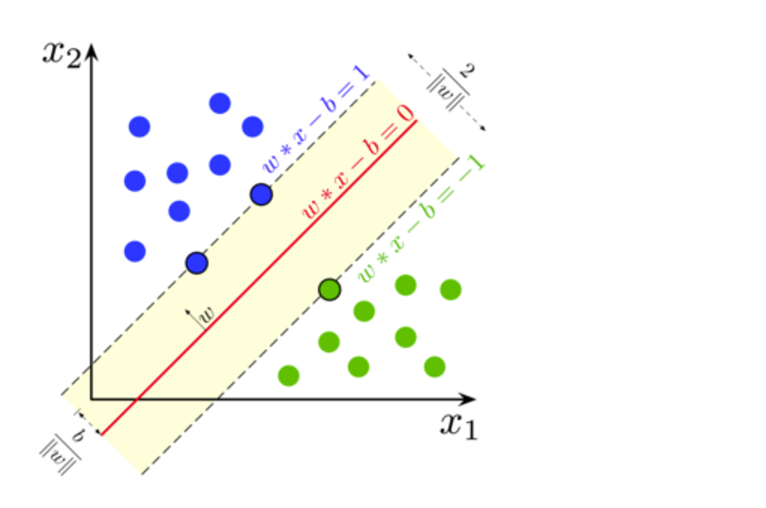

The above figure shows the case when there are two features in the data. For three features, SVM will try to find the best plane, and for four or more features, it would try to find the best hyperplane.

To perform the optimization, the ML model minimizes |w| subject to the following constraint:

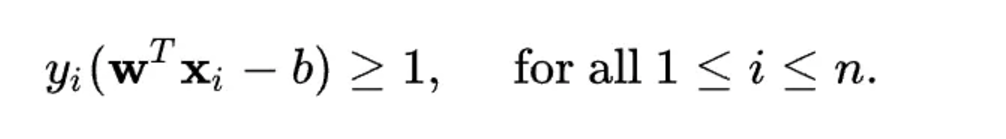

in which yᵢ is the label (i.e -1 or 1), w is the normal vector to the hyperplane, xᵢ is the feature vector, and b is the bias.

One of the main benefits of SVM is that, unlike many ML methods that use the Gradient Descent Algorithm to find the optimal model to predict test data, the vector machine method does not get blocked by local optimal points, as it is a convex optimization problem. This, by itself, makes SVM one of the strongest classification ML models that are available to us.


Therefore, we can wrap everything up using Lagrange multipliers. We construct the Lagrangian:

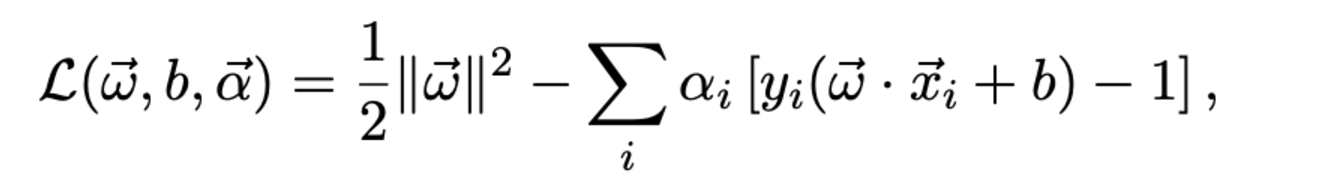

where αi are the Lagrange multipliers. There is a subtlety. Only the αi connected with points that are in the boundaries are going to be nonzero. All the rest are going to be zero.


To find the minimum of the Lagrangian, we set the derivatives equal to 0. As ω is just a linear combination of the points in our training data set. We can take this expression for ω and insert it back into the Lagrangian:

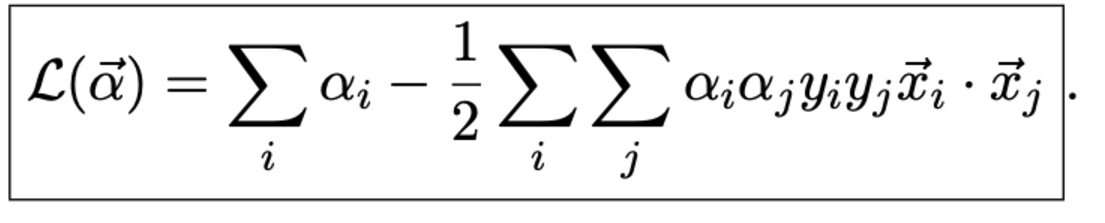

In conclusion, finding the ω and b that separates my data sets is equivalent to minimizing a Lagrangian that only depends on α. The procedure is just to send all the training data (x, y) to a classical computer that computes the Lagrangian and then minimizes it, finding the optimal α. Then, this alpha is used to compute ω and b.

The Lagrangian has a very particular form. It is quadratic and convex, which means that one can always find the global minimum of it by applying conventional numerical minimization techniques, in opposition to other machine learning methods like neural networks, that have multiple local minima and often get stuck in them.

## Kernel trick to introduce nonlinearities

The main disadvantage of the Linear Support Vector Machine is that we assumed from the beginning that it existed a straight line that could separate my data in two sets. This is not always the case.

How can we deal with these types of data sets without having to renounce to the special properties we have found (quadratic and convex formula)? 

The idea is to look for some transformation of the data set such that the problem becomes linearly separable. This transformation can be, for instance, mapping the data from the original space into a higher dimensional feature space:

* Data set: collection one dimensional points {$x_i$}.
* Transformation: $x_i$ → φ($x_i$) = ($x_i$, $x_i^2$ )

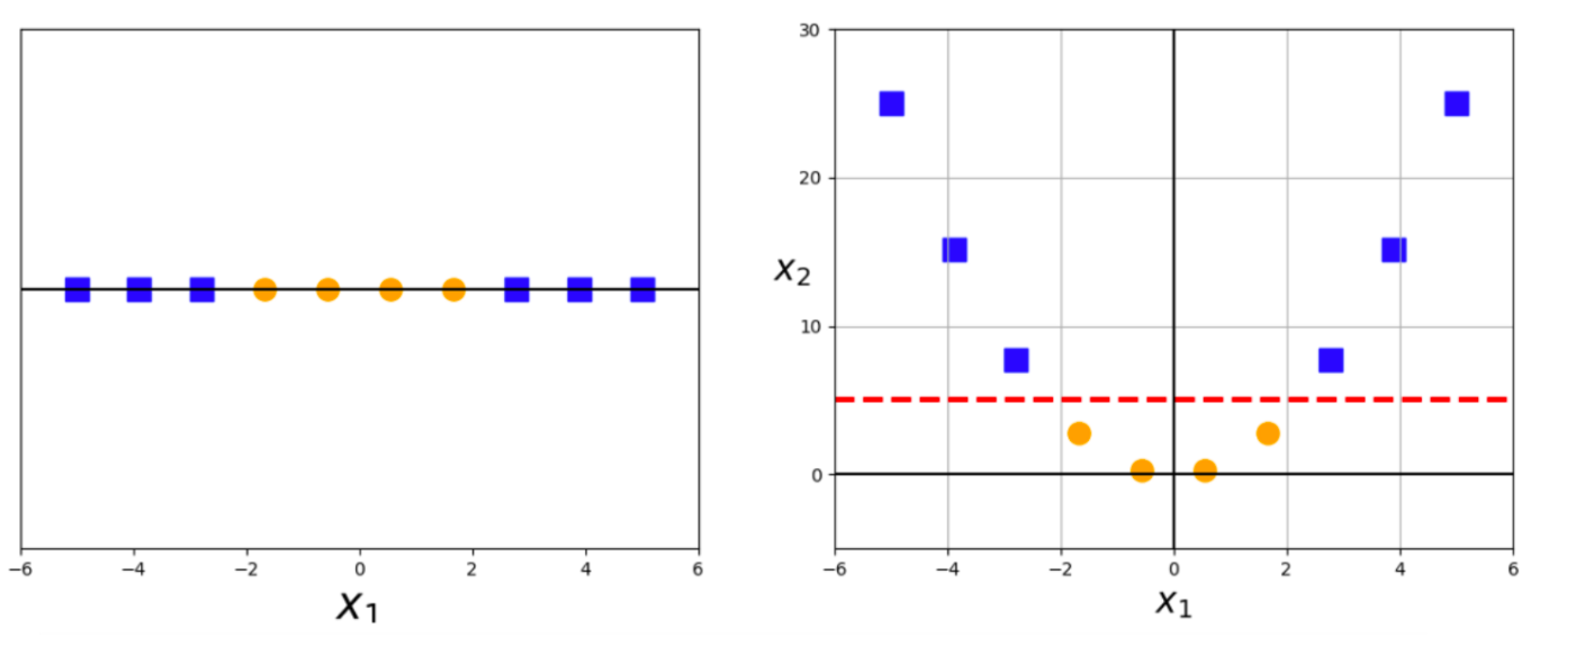

In order to find the line that separates our data, we just need to minimize the Lagrangian:

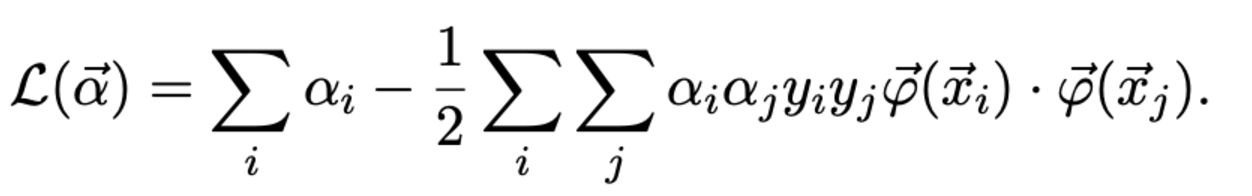

This way, we keep all the interesting properties of the original Lagrangian. 

There is only one problem: mapping the original data to another space can be computationally expensive, especially when working with very high dimensions, and on top of that we then have to perform operations with the higher dimensional vectors.

The **kernel trick** provides a solution to this problem. The “trick” is that we only need the dot product of the transformed data, not the transformed data itself. We may find an operation that satisfies

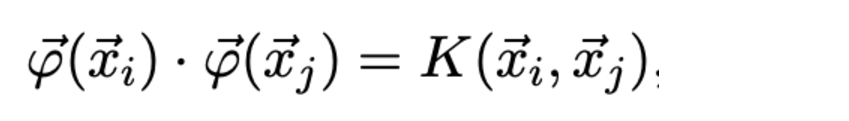


## Quantum Kernel Machine Learning

In quantum kernel machine learning, a quantum feature map $\phi(\vec{x})$ is used to map a classical feature vector $\vec{x}$ to a quantum Hilbert space, $| \phi(\vec{x})\rangle \langle \phi(\vec{x})|$, such that $K_{ij} = \left| \langle \phi^\dagger(\vec{x}_j)| \phi(\vec{x}_i) \rangle \right|^{2}$.

In this notebook, we use `qiskit` to calculate a kernel matrix using a quantum feature map, then use this kernel matrix in `scikit-learn` classification and clustering algorithms.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit import quantum_info

from qiskit_aer import AerSimulator
# from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler

## Classification

For our classification example, we will use the _iris dataset_ reduced to only 2 species and 2 features, and the `scikit-learn` [support vector machine](https://scikit-learn.org/stable/modules/svm.html) classification (`svc`) algorithm.  

If it is desired to use the full dataset, just use the code that is on top of the actual dataset selection code

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import datasets
import pandas as pd

# Load the iris data from scikit-learn
iris = datasets.load_iris()

# Convert the data to a pandas DataFrame
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["species"] = iris.target

# Filter the data to keep only versicolor and virginica
iris_df = iris_df[iris_df["species"].isin([1, 2])]

# Replace the species numbers with numerical labels
iris_df["species"] = iris_df["species"].map({1: 1, 2: 0})

# Define features and labels
X = iris_df.drop(['species'], axis=1)
y = iris_df['species']

# In order to do it with the full dataset use this code instead of the code below

X = iris_df.drop(['species'], axis=1)
y = iris_df['species']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

# Display the first 5 rows of the filtered data
print(X_train.head())

"""
# Split the dataset into training (5 samples) and testing (3 samples) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3/8, random_state=42, stratify=y)

# Select 5 unique rows for training and 3 unique rows for testing
X_train = X_train.sample(5, random_state=42)
y_train = y_train[X_train.index]
X_test = X_test.sample(3, random_state=42)
y_test = y_test[X_test.index]

# Display the training and testing sets
print("Training Set (X_train):")
print(X_train)
print("\nTraining Labels (y_train):")
print(y_train)
print("\nTesting Set (X_test):")
print(X_test)
print("\nTesting Labels (y_test):")
print(y_test)
"""

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
105                7.6               3.0                6.6               2.1
138                6.0               3.0                4.8               1.8
76                 6.8               2.8                4.8               1.4
92                 5.8               2.6                4.0               1.2
119                6.0               2.2                5.0               1.5


'\n# Split the dataset into training (5 samples) and testing (3 samples) sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3/8, random_state=42, stratify=y)\n\n# Select 5 unique rows for training and 3 unique rows for testing\nX_train = X_train.sample(5, random_state=42)\ny_train = y_train[X_train.index]\nX_test = X_test.sample(3, random_state=42)\ny_test = y_test[X_test.index]\n\n# Display the training and testing sets\nprint("Training Set (X_train):")\nprint(X_train)\nprint("\nTraining Labels (y_train):")\nprint(y_train)\nprint("\nTesting Set (X_test):")\nprint(X_test)\nprint("\nTesting Labels (y_test):")\nprint(y_test)\n'

To prepare data for a Quantum Support Vector Machine (QSVM), we scale features to \([0, 2*pi]\) to encode them as rotation angles in quantum circuits. This ensures compatibility with quantum gates, preserves feature relationships, and balances their contributions. The scaler is fit only on the training set to avoid data leakage and ensure fair model evaluation. Here's how to do it:

In [16]:
# Scale features to the range [0, 2*pi] - fit on training set only
scaler = MinMaxScaler(feature_range=(0, 2 * np.pi))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Display the first 5 rows of the filtered data
print(X_train.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           5.654867          3.141593           5.799863          4.607669
1           2.303835          3.141593           2.899932          3.351032
2           3.979351          2.356194           2.899932          1.675516
3           1.884956          1.570796           1.611073          0.837758
4           2.303835          0.000000           3.222146          2.094395


This plot helps visualize the relationship between selected features (`sepal length` and `petal width`) while distinguishing training and testing datasets. Color coding by target labels (e.g., species) provides insights into class separability and feature relevance. Differentiating training (circles) and testing (crosses) ensures a clear understanding of data splits. The visualization helps identify patterns, clusters, or overlaps, guiding preprocessing or model selection. It’s a quick way to validate the dataset's structure and class distribution.

C:\Users\nacho\AppData\Local\Temp\ipykernel_12000\687820741.py:9: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test['sepal length (cm)'], X_test['petal width (cm)'],


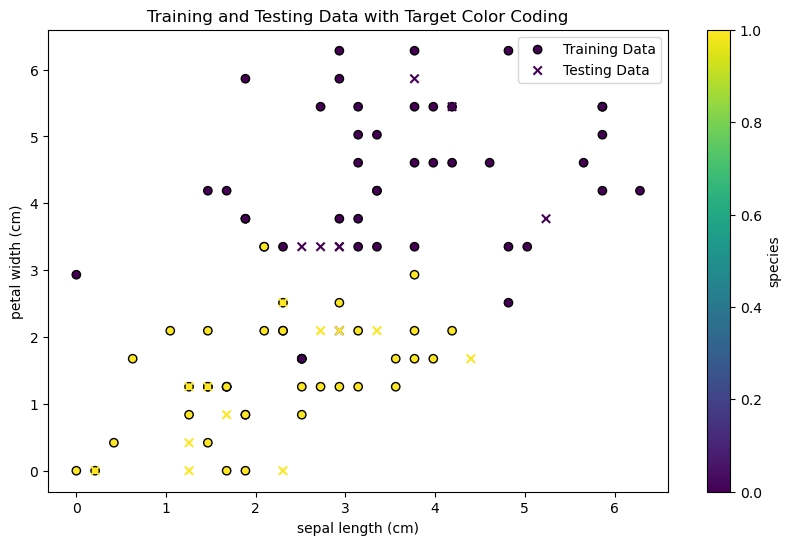

In [18]:
# Plotting
plt.figure(figsize=(10, 6))

# Training data
plt.scatter(X_train['sepal length (cm)'], X_train['petal width (cm)'], 
            c=y_train, cmap='viridis', marker='o', label='Training Data', edgecolor='k')

# Testing data
plt.scatter(X_test['sepal length (cm)'], X_test['petal width (cm)'], 
            c=y_test, cmap='viridis', marker='x', label='Testing Data', edgecolor='k')

# Adding labels and legend
plt.xlabel("sepal length (cm)")
plt.ylabel("petal width (cm)")
plt.colorbar(label="species")
plt.legend()
plt.title("Training and Testing Data with Target Color Coding")
plt.show()

# Classical SVM

This code trains a Support Vector Machine (SVM) classifier with a Gaussian (RBF) kernel. The model is fit using the training dataset and predicts labels for the test dataset. The RBF kernel helps capture complex, non-linear patterns in the data by mapping it into a higher-dimensional space. The performance is evaluated using accuracy, which is printed to assess the model’s success in classification.

In [21]:
#Create a svm Classifier
clf = SVC(kernel='rbf') # gauss Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9


In [22]:
print(classification_report(y_test, y_pred))
# When running with the small set an error pops, to get rid of it just run the code woth the full data set

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.92      0.92      0.92        12

    accuracy                           0.90        20
   macro avg       0.90      0.90      0.90        20
weighted avg       0.90      0.90      0.90        20



This code uses Seaborn to create a heatmap visualization of the normalized confusion matrix, which provides a detailed view of classification performance. Each cell shows the proportion of predictions for each class, making it easier to interpret model accuracy and errors. The `annot=True` argument adds values to the cells, and the `Blues` colormap enhances readability. The background is set to transparent for cleaner integration into presentations or reports.


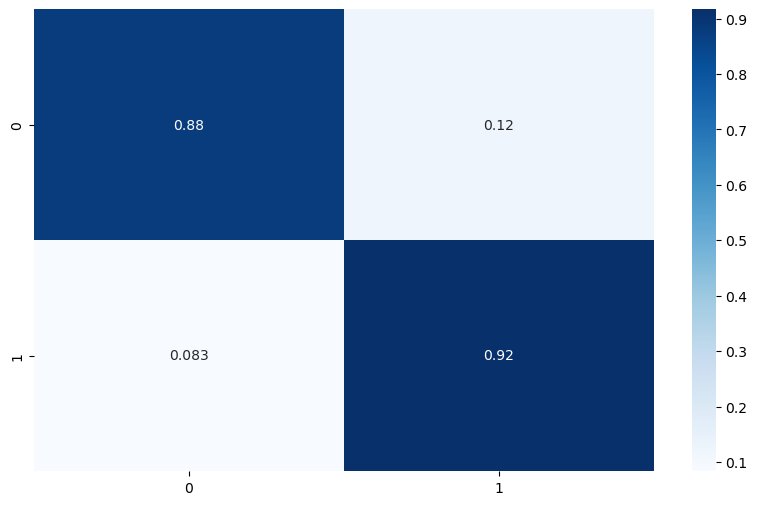

In [24]:
import seaborn as sns

ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'),annot=True,cmap='Blues')
ax.patch.set_alpha(0) # make the background transparent
plt.show() 

# Create our own Kernel 

### Computing a Cosine Similarity Kernel

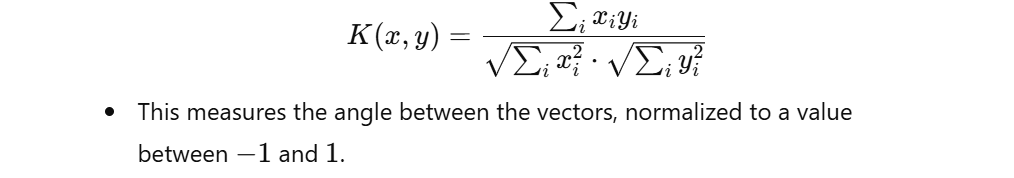

This code computes a kernel matrix using the cosine similarity kernel, which measures the angle between feature vectors. It calculates the kernel value for each pair of data points, emphasizing their directional alignment. By normalizing the feature vectors, it ensures robustness to magnitude differences in the data. The resulting kernel matrix is visualized as a heatmap, providing insights into pairwise similarities in the training set. Cosine similarity kernels are particularly useful when the relative orientation of data points is more important than their magnitudes.


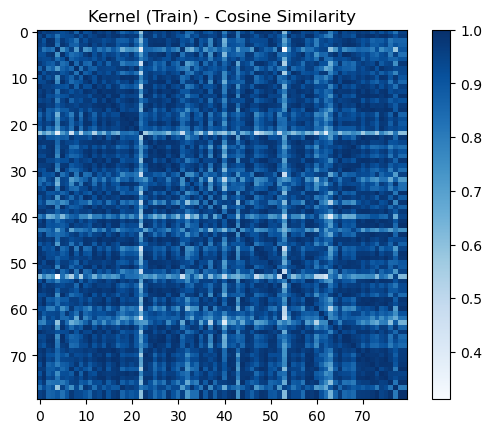

In [27]:
# Import numpy library
import numpy as np

# Define the cosine similarity kernel function
def kernel(x, y):
    # Extract the features from x and y
    sli, swi, pli, pwi = x[:4] # sepal length, sepal width, petal length, petal width
    slj, swj, plj, pwj = y[:4]
    # Compute the kernel value (cosine similarity)
    return (sli*slj + swi*swj + pli*plj + pwi*pwj) / (
        np.sqrt(sli**2 + swi**2 + pli**2 + pwi**2) * 
        np.sqrt(slj**2 + swj**2 + plj**2 + pwj**2)
    )

# Create an empty matrix to store the kernel values
K = np.zeros((len(X_train), len(X_train)))

# Loop over the rows of X_train
for i in range(len(X_train)):
    # Loop over the columns of X_train
    for j in range(len(X_train)):
        # Compute the kernel value for each pair of data points
        K[i, j] = kernel(X_train.iloc[i], X_train.iloc[j])

# Plot the kernel matrix as a heatmap
plt.imshow(K, cmap="Blues")
plt.title("Kernel (Train) - Cosine Similarity")
plt.colorbar()
plt.show()



This code trains a Support Vector Machine (SVM) using a precomputed kernel matrix `K`(the one we made before), which defines pairwise similarities between training samples. The `fit` method uses the custom kernel matrix and training labels `y_train` to learn a classification model. This approach is useful for incorporating non-standard kernels into the SVM.


In [29]:
clf = SVC(gamma='auto', kernel='precomputed')
clf.fit(K, y_train)

SVC(gamma='auto', kernel='precomputed')

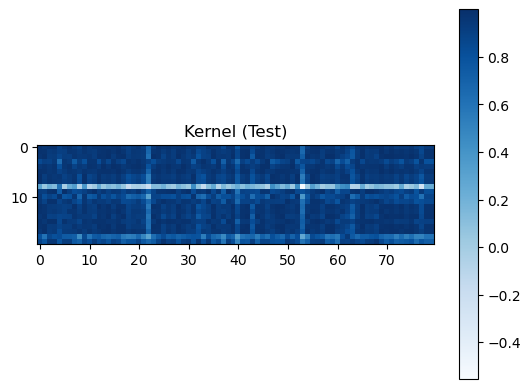

In [30]:
# Create an empty matrix to store the kernel values
K_test = np.zeros((len(X_test), len(X_train)))

# Loop over the rows of iris_df
for i in range(len(X_test)):
    # Loop over the columns of iris_df
    for j in range(len(X_train)):
        # Compute the kernel value for each pair of data points
        K_test[i, j] = kernel(X_test.iloc[i], X_train.iloc[j])

# Plot the kernel matrix as a heatmap
plt.imshow(K_test, cmap="Blues")
plt.title("Kernel (Test)")
plt.colorbar()
plt.show()


This code uses the trained SVM to predict labels for the test set (`K_test`) and evaluates performance using a classification report. The report provides metrics like precision, recall, and F1-score for each class.


In [32]:
y_pred = clf.predict(K_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       1.00      0.58      0.74        12

    accuracy                           0.75        20
   macro avg       0.81      0.79      0.75        20
weighted avg       0.85      0.75      0.75        20



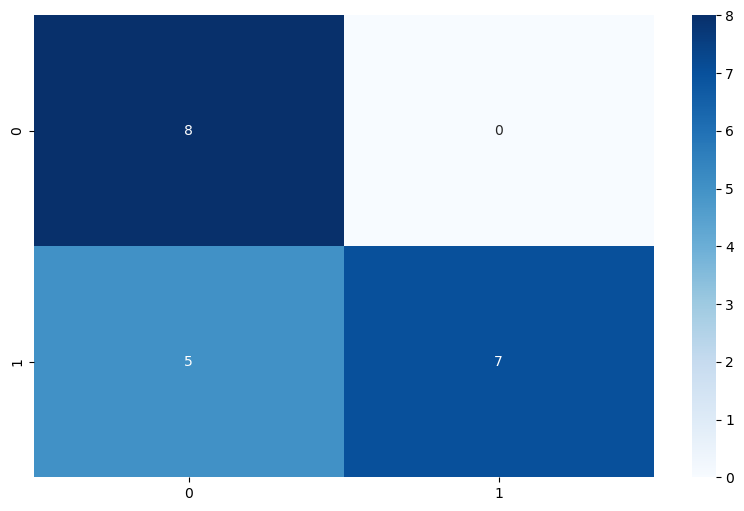

In [33]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,cmap='Blues')
ax.patch.set_alpha(0) # make the background transparent
plt.show() 

# Quantum Kernel

With our training and testing datasets ready, we set up the `FidelityQuantumKernel` class to calculate a kernel matrix using the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html). We use the reference implementation of the `Sampler` primitive and the `ComputeUncompute` fidelity that computes overlaps between states. These are the default values and if you don't pass a `Sampler` or `Fidelity` instance, the same objects will be created automatically for you.

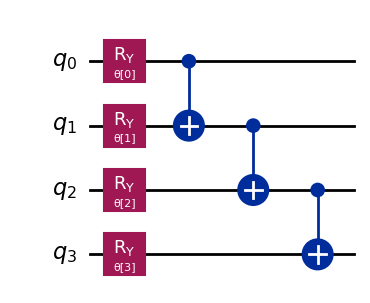

In [36]:
# Define the number of qubits
n = 4

# Create a parameter vector with 'n' parameters named θ
thetas = ParameterVector('θ', n)

# Initialize a quantum circuit with 'n' qubits
qc = QuantumCircuit(n)

# Apply a parameterized Ry rotation to each qubit
for i, t in enumerate(thetas):
    qc.ry(t, i)

# Apply a chain of CNOT gates to entangle consecutive qubits
for i in range(n-1):
    qc.cx(i, i+1)

# Draw the circuit as a matplotlib figure
qc.draw('mpl')


In [37]:
# We assign some theta values
theta_values = [5.654867, 3.141593, 5.799863, 4.6076694]

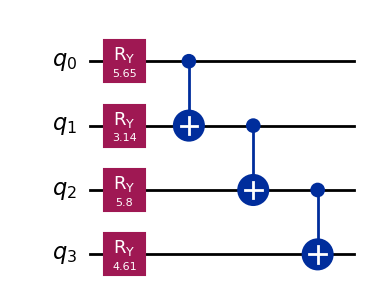

In [38]:
# Bind specific values to the parameters in the quantum circuit
bound_circuit = qc.assign_parameters(theta_values)

# Draw the parameterized circuit with the assigned values as a matplotlib figure
bound_circuit.draw('mpl')


In [39]:

# Import the quantum information module from Qiskit
from qiskit import quantum_info

# Simulate the statevector of the quantum circuit with the bound parameters
initial_state = quantum_info.Statevector.from_instruction(bound_circuit)

# Draw the resulting statevector in LaTeX format for a clean representation
initial_state.draw('latex')


<IPython.core.display.Latex object>

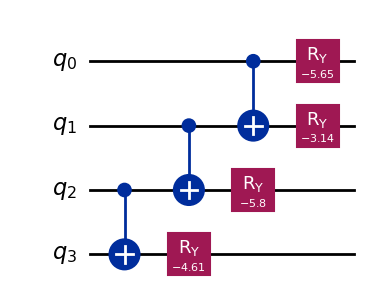

In [40]:
# Generate the inverse (uncomputation) of the quantum circuit
uncompute_circuit = bound_circuit.inverse()

# Draw the uncomputed (inverted) circuit as a matplotlib figure
uncompute_circuit.draw('mpl')


In [41]:

# Create a new quantum circuit to build the kernel circuit
kernel_circuit_bound = QuantumCircuit(4)

# Append the forward (bound) circuit as an instruction, acting on all 4 qubits
kernel_circuit_bound.append(bound_circuit.to_instruction(), [0, 1, 2, 3])

# Append the inverse (uncomputed) circuit as an instruction, also acting on all 4 qubits
kernel_circuit_bound.append(uncompute_circuit.to_instruction(), [0, 1, 2, 3])


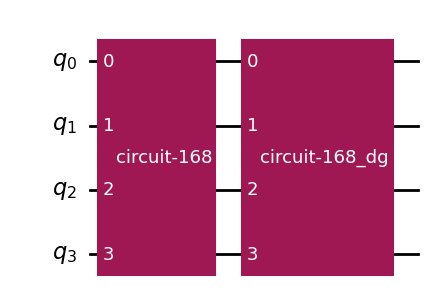

In [42]:
kernel_circuit_bound.draw('mpl')

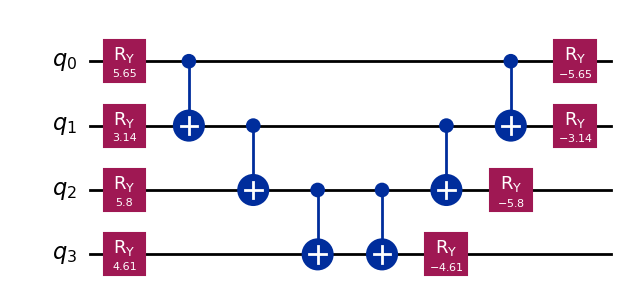

In [43]:
kernel_circuit_bound.decompose().draw('mpl')

In [44]:
# Simulate the statevector of the combined kernel circuit (forward + uncompute)
initial_state = quantum_info.Statevector.from_instruction(kernel_circuit_bound)

# Draw the resulting statevector in LaTeX format for a clear and detailed representation
initial_state.draw('latex')


<IPython.core.display.Latex object>

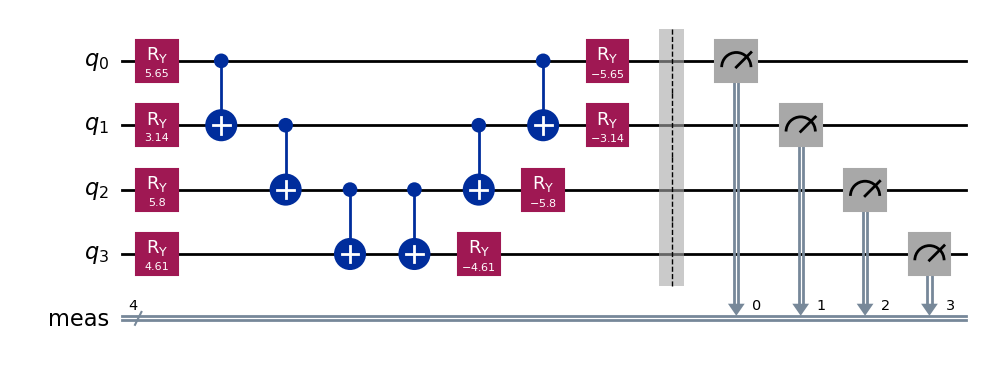

In [45]:
kernel_circuit_bound.measure_all()
kernel_circuit_bound.decompose().draw('mpl')

Using `with Session(backend=aer_sim)...` ensures efficient resource management and maintains a consistent connection to the backend during execution. It automatically handles session setup and teardown, preventing potential resource leaks or unnecessary overhead.

In [47]:
# Initialize the AerSimulator backend for simulation
aer_sim = AerSimulator()

# Generate a preset pass manager with optimization level 1 for the given backend
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

# Optimize and transpile the quantum circuit using the pass manager
isa_qc = pm.run(kernel_circuit_bound)

# Open a session with the AerSimulator backend
with Session(backend=aer_sim) as session:
    # Initialize a Sampler primitive to compute measurement outcomes
    sampler = Sampler(mode=session)
    
    # Execute the optimized quantum circuit and get the result
    result = sampler.run([isa_qc]).result()
    
    # Access the first result (from the first circuit) and get measurement counts
    pub_result = result[0]
    counts = pub_result.data.meas.get_counts()

# Print the measurement counts (how often each bitstring was observed)
print(counts)

{'0000': 1024}


### Why the Outcome is Always `0000`

The outcome is always `0000` because the kernel circuit combines a forward circuit (`bound_circuit`) and its exact inverse (`uncompute_circuit`). The inverse uncomputes all operations, returning the system to its initial state. Since the qubits start in the ground state \(|0000}), they return to \(|0000}) after the kernel circuit. As a result, all measurements consistently yield the bitstring `0000`.

This happens when the values we give to the compute circuit are exactly the same that the we give to the uncompute circuit

In [49]:
print(counts['0000']/1024)

1.0


### Quantum Kernel Calculation Function

This function computes the quantum kernel value between two data points, `x` and `y`, using a parameterized quantum circuit. The kernel circuit consists of a forward circuit that encodes `x`, followed by the inverse circuit that encodes `y`, creating interference patterns that capture their similarity. The circuit includes parameterized \( R_y \) and \( R_z \) rotations for feature encoding and \( CNOT \) and \( CZ \) gates for entanglement. Measurements are performed on the qubits, and the probability of the `0000` state is returned as the kernel value. This setup allows for the evaluation of complex, non-linear relationships in the feature space.


In [51]:
def build_kernel_circuit(x, y):
    """Builds the quantum circuit used for quantum kernel calculation.
    
    Args:
        x (array-like): Feature vector for the first data point.
        y (array-like): Feature vector for the second data point.
    
    Returns:
        QuantumCircuit: The combined quantum kernel circuit.
    """
    
    n = 4  # Number of qubits (one for each feature in the data point)
    thetas = ParameterVector('θ', n)  # Define a parameter vector θ with n parameters

    # Create the forward circuit to encode the features of data point x
    qc = QuantumCircuit(n)  # Initialize a quantum circuit with n qubits
    for i, t in enumerate(thetas):  
        qc.ry(t, i)  # Apply parameterized Ry rotation gates to each qubit
    for i in range(n):  
        qc.rz(thetas[i], i)  # Apply parameterized Rz rotation gates to each qubit
    for i in range(n - 1):  
        qc.cx(i, i + 1)  # Entangle adjacent qubits using CNOT gates
        qc.cz(i, i + 1)  # Add additional entanglement using CZ gates
    bound_circuit = qc.assign_parameters(x[:4])  # Bind feature values from x to the parameters θ

    # Create the inverse circuit to encode the features of data point y
    qc2 = QuantumCircuit(n)  # Initialize a quantum circuit for y
    for i, t in enumerate(thetas):  
        qc2.ry(t, i)  # Apply parameterized Ry rotation gates to each qubit
    for i in range(n):  
        qc2.rz(thetas[i], i)  # Apply parameterized Rz rotation gates to each qubit
    for i in range(n - 1):  
        qc2.cx(i, i + 1)  # Entangle adjacent qubits using CNOT gates
        qc2.cz(i, i + 1)  # Add additional entanglement using CZ gates
    uncompute_circuit = qc2.inverse().assign_parameters(y[:4])  # Bind feature values from y and invert the circuit

    # Combine the forward and inverse circuits into a single kernel circuit
    kernel_circuit = QuantumCircuit(n)  # Initialize the kernel circuit with n qubits
    kernel_circuit.append(bound_circuit.to_instruction(), range(n))  # Add the forward circuit
    kernel_circuit.append(uncompute_circuit.to_instruction(), range(n))  # Add the inverse circuit

    return kernel_circuit  # Return the combined kernel circuit



Quantum Kernel Circuit:


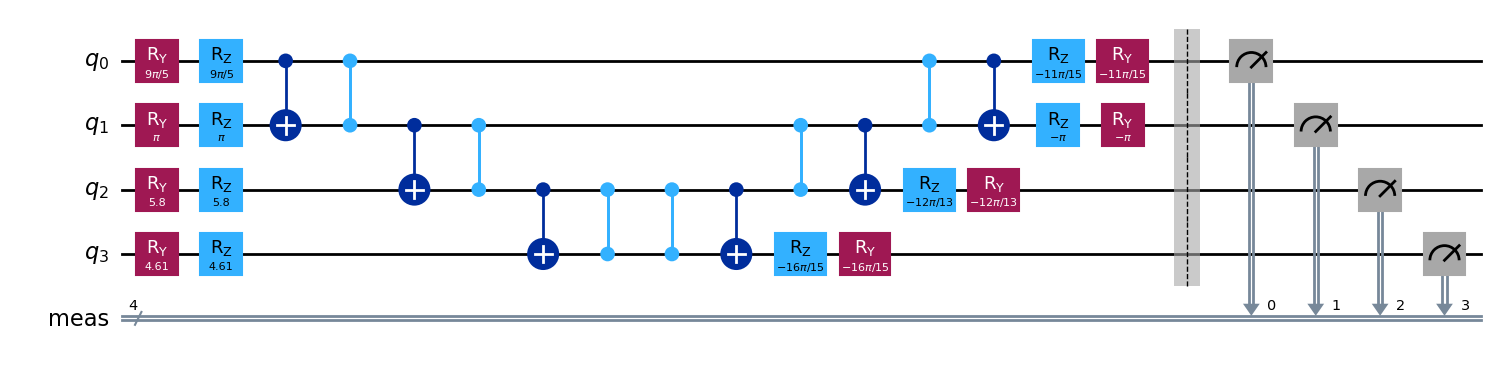

In [52]:
# Example data points for demonstration
example_x = X_train.iloc[0]  # Use the first data point as an example
example_y = X_train.iloc[1]  # Use the second data point as an example

# Build the kernel circuit for demonstration
example_circuit = build_kernel_circuit(example_x, example_y)

# Draw the circuit once as an MPL diagram
print("Quantum Kernel Circuit:")
example_circuit.draw('mpl')  # Use MPL for visualizing the circuit
example_circuit.measure_all()
example_circuit.decompose().draw('mpl')

In [53]:
def quantum_kernel(x, y, sampler):
    """Computes the quantum kernel value for two input data points x and y."""
    # Build the kernel circuit using the helper function
    kernel_circuit = build_kernel_circuit(x, y)

    # Add measurement operations to the circuit
    kernel_circuit.measure_all()  # Measure all qubits to collect classical outcomes

    # Optimize the circuit for execution on the simulator backend
    pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=1)  # Create a pass manager for optimization
    isa_qc = pm.run(kernel_circuit)  # Transpile and optimize the circuit

    # Execute the circuit using the provided sampler
    result = sampler.run([isa_qc]).result()  # Run the sampler and get the result
    pub_result = result[0]  # Extract the first result (as we run only one circuit)
    counts = pub_result.data.meas.get_counts()  # Get the measurement counts for all outcomes

    # Return the probability of observing the all-zero state ('0000')
    return counts.get('0000', 0) / 1024  # Normalize counts by the number of shots

In [54]:
# Initialize the AerSimulator backend for quantum circuit simulation
aer_sim = AerSimulator()

# Start a session with the AerSimulator backend to manage resource allocation and execution
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the quantum kernel values
    K_q = np.zeros((len(X_train), len(X_train)))  # Matrix size matches the number of training samples

    # Initialize the sampler primitive, which evaluates quantum circuits
    sampler = Sampler(mode=session)

    # Loop over each pair of training data points to compute the kernel matrix
    for i in range(len(X_train)):  # Outer loop iterates over rows
        print(i, "/", len(X_train))  # Progress tracking for long-running computations

        for j in range(len(X_train)):  # Inner loop iterates over columns
            # Compute the kernel value for the data pair (i, j) using the quantum_kernel function
            try:
                K_q[i, j] = quantum_kernel(X_train.iloc[i], X_train.iloc[j], sampler)
            except:  # Handle any errors during kernel computation
                K_q[i, j] = 0  # Assign 0 if an error occurs to ensure the matrix is complete

# Display the computed kernel matrix
print(K_q)


0 / 80
1 / 80
2 / 80
3 / 80
4 / 80
5 / 80
6 / 80
7 / 80
8 / 80
9 / 80
10 / 80
11 / 80
12 / 80
13 / 80
14 / 80
15 / 80
16 / 80
17 / 80
18 / 80
19 / 80
20 / 80
21 / 80
22 / 80
23 / 80
24 / 80
25 / 80
26 / 80
27 / 80
28 / 80
29 / 80
30 / 80
31 / 80
32 / 80
33 / 80
34 / 80
35 / 80
36 / 80
37 / 80
38 / 80
39 / 80
40 / 80
41 / 80
42 / 80
43 / 80
44 / 80
45 / 80
46 / 80
47 / 80
48 / 80
49 / 80
50 / 80
51 / 80
52 / 80
53 / 80
54 / 80
55 / 80
56 / 80
57 / 80
58 / 80
59 / 80
60 / 80
61 / 80
62 / 80
63 / 80
64 / 80
65 / 80
66 / 80
67 / 80
68 / 80
69 / 80
70 / 80
71 / 80
72 / 80
73 / 80
74 / 80
75 / 80
76 / 80
77 / 80
78 / 80
79 / 80
[[1.         0.02050781 0.02441406 ... 0.42480469 0.00195312 0.00390625]
 [0.0390625  1.         0.36816406 ... 0.06933594 0.57128906 0.57714844]
 [0.02148438 0.375      1.         ... 0.12207031 0.46875    0.45410156]
 ...
 [0.44824219 0.05175781 0.109375   ... 1.         0.16113281 0.11328125]
 [0.00683594 0.56835938 0.44628906 ... 0.12207031 1.         1.        ]


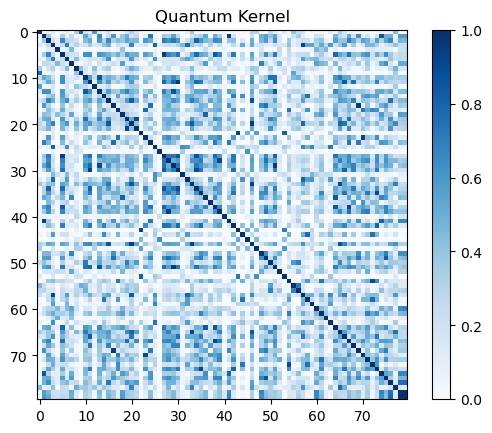

In [55]:
# Import matplotlib library
import matplotlib.pyplot as plt

# Plot the kernel matrix as a heatmap
plt.imshow(K_q, cmap="Blues")
plt.title("Quantum Kernel")
plt.colorbar()
plt.show()

In [56]:
clf = SVC(gamma='auto', kernel='precomputed')
clf.fit(K_q, y_train)

SVC(gamma='auto', kernel='precomputed')

In [57]:
with Session(backend=aer_sim) as session:
    # Create an empty matrix to store the kernel values
    K_test = np.zeros((len(X_test), len(X_train)))

    sampler = Sampler(mode=session)
    # Loop over the rows of iris_df
    for i in range(len(X_test)):
        print(i, "/", len(X_test))
        # Loop over the columns of iris_df
        for j in range(len(X_train)):
            # Compute the kernel value for each pair of data points
            try:
                K_test[i, j] = quantum_kernel(X_test.iloc[i], X_train.iloc[j], sampler)
            except:
                K_test[i, j] = 0
# Display the kernel matrix
print(K_test)

0 / 20
1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
[[0.00292969 0.53613281 0.66796875 ... 0.08007812 0.48535156 0.49316406]
 [0.02636719 0.61523438 0.32226562 ... 0.13574219 0.43359375 0.42578125]
 [0.08105469 0.07128906 0.37109375 ... 0.40527344 0.09082031 0.10546875]
 ...
 [0.01464844 0.97851562 0.34472656 ... 0.046875   0.54101562 0.53320312]
 [0.         0.         0.02148438 ... 0.02050781 0.01367188 0.01367188]
 [0.03125    0.         0.01660156 ... 0.078125   0.00878906 0.01269531]]


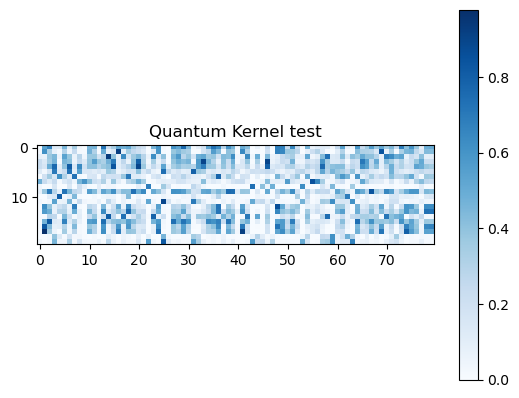

In [58]:
# Import matplotlib library
import matplotlib.pyplot as plt

# Plot the kernel matrix as a heatmap
plt.imshow(K_test, cmap="Blues")
plt.title("Quantum Kernel test")
plt.colorbar()
plt.show()

In [59]:
y_pred_q = clf.predict(K_test)
acc_q = accuracy_score(y_test, y_pred_q)

print(acc_q)

0.8


In [60]:
accuracy_score(y_pred, y_pred_q)

0.85

In [61]:
print(classification_report(y_test, y_pred_q))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       1.00      0.67      0.80        12

    accuracy                           0.80        20
   macro avg       0.83      0.83      0.80        20
weighted avg       0.87      0.80      0.80        20



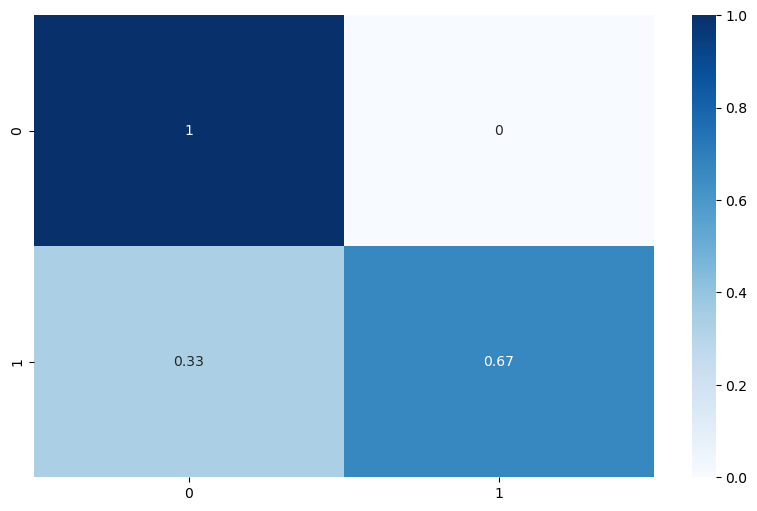

In [62]:
ax = plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_q, normalize='true'),annot=True,cmap='Blues')
ax.patch.set_alpha(0) # make the background transparent
plt.show() 